In [1]:
import pandas as pd
from my_pysyncon import Dataprep, Synth

In [2]:
df_mo = pd.read_csv('../../../Dataset_Generation/Jared/Data/total_state_data.csv')
df_mo['co2_per_capita'] = df_mo['total_co2'] / df_mo['population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017'] / df_mo['population']
df_mo['eprod_per_capita'] = df_mo['energy_prod'] / df_mo['population']
df_mo['eflow_per_capita'] = df_mo['energy_flow'] / df_mo['population']

df_yr = pd.read_csv('../../../Dataset_Generation/Jared/Data/yearly_total_data.csv')
df_yr['co2_per_capita'] = df_yr['total_co2'] / df_yr['population']
df_yr['gdp_per_capita'] = df_yr['gdp_rel_2017'] / df_yr['population']

In [15]:
df_mo.head()

,state,date,population,total_co2,prcp,snow,tavg,gdp_rel_2017,energy_prod,energy_use,energy_flow,co2_per_capita,gdp_per_capita,eprod_per_capita,eflow_per_capita
0,AL,1990-01-01,4050055.0,4.262280e+06,7.89,0.0,46.8,NaN,1269484.0,1599432.0,-329948.0,1.052401,NaN,0.313449,-0.081468
1,AL,1990-02-01,4050055.0,3.698828e+06,9.35,0.0,51.9,NaN,1269484.0,1599432.0,-329948.0,0.913278,NaN,0.313449,-0.081468
2,AL,1990-03-01,4050055.0,3.780858e+06,8.92,0.0,54.2,NaN,1269484.0,1599432.0,-329948.0,0.933533,NaN,0.313449,-0.081468
3,AL,1990-04-01,4050055.0,3.472907e+06,4.48,0.0,59.7,NaN,1269484.0,1599432.0,-329948.0,0.857496,NaN,0.313449,-0.081468
4,AL,1990-05-01,4050055.0,4.191628e+06,4.38,0.0,67.3,NaN,1269484.0,1599432.0,-329948.0,1.034956,NaN,0.313449,-0.081468


In [ ]:
time_range = df_mo.date

# these are the time values where CO2 emissions are fit
preintervention_time_range = df_mo.date[df_mo.date<'2009-01-01']

# these are the time values where our features are fit (subset of preintervention_time_range)
preintervention_feature_range = df_mo.date[(df_mo.date >= '1997-01-01') & (df_mo.date<'2009-01-01')]

We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [ ]:
# we leave off RGGI states, states with no CO2 data (AK, HI), as well as states with some type of cap-and-trade program (CA)

non_rggi_controls_identifier= [
    "AL", 
    #"AK", 
    "AZ", "AR", 
    #"CA", 
    "CO", 
    #"CT", 
    #"DE", 
    "FL", "GA",
    #"HI", 
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", 
    #"ME", 
    #"MD",
    #"MA", 
    "MI", "MN", "MS", "MO", "MT", "NE", "NV", 
    #"NH", 
    #"NJ",
    "NM", "NC", "ND", "OH", "OK", "OR", "PA", 
    #"RI", 
    "SC", "SD", "TN", "TX", "UT", 
    #"VT", 
    #"VA", 
    "WA", "WV", "WI", "WY"
    ]

In [ ]:
# we create a synthetic control for Delaware

dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['prcp', 'snow', 'tavg','gdp_per_capita','eprod_per_capita','eflow_per_capita'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
)

print(dataprep_mo)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: AL, AZ, AR, CO, FL, GA, ID, IL, IN, IA, KS, KY, LA, MI, MN, MS, MO, MT, NE, NV, NM, NC, ND, OH, OK, OR, PA, SC, SD, TN, TX, UT, WA, WV, WI, WY
Time range in data: 1990-01-01 - 2024-12-01
Time range for loss minimization: 0        1990-01-01
1        1990-02-01
2        1990-03-01
3        1990-04-01
4        1990-05-01
            ...    
20473    2008-08-01
20474    2008-09-01
20475    2008-10-01
20476    2008-11-01
20477    2008-12-01
Name: date, Length: 11172, dtype: object
Time range for predictors: 84       1997-01-01
85       1997-02-01
86       1997-03-01
87       1997-04-01
88       1997-05-01
            ...    
20473    2008-08-01
20474    2008-09-01
20475    2008-10-01
20476    2008-11-01
20477    2008-12-01
Name: date, Length: 7056, dtype: object
Predictors: prcp, snow, tavg, gdp_per_capita, eprod_per_capita, eflow_per_capita




We supply the `Dataprep` object to a `Synth` object. The optimisation scheme we could use is [BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) and the starting point we could use for the optimisation is `ols` i.e. the initial weights are obtained by fitting an ordinary-least-squares estimate. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point.*

In [10]:
synth_mo = Synth()
synth_mo.fit(dataprep=dataprep_mo)
print(synth_mo.weights(threshold=.01))

IL    0.493
MN    0.015
NV    0.491
Name: weights, dtype: float64


This is saying that Delaware is $49.3\%$ Illinois, $49.1\%$ Nevada, and $1.5\%$ Minnesota (all other percentages are negligible).


In [ ]:
# these are the dates used for our graph

years= ['1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
        '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01', 
        '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
        '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01', 
        '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01', 
        '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', 
        '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', 
        '2018-01-01', '2019-01-01', '2020-01-01']

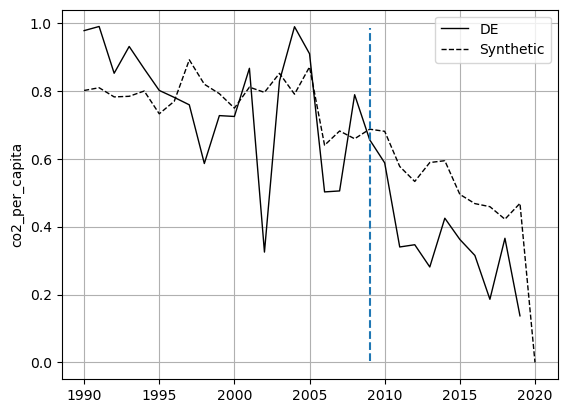

In [13]:
synth_mo.path_plot(time_period=years, treatment_time='2009-01-01')

The summary function give more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [16]:
synth_mo.summary()

,V,treated,synthetic,sample mean
prcp,0.003,3.916,1.692,2.694
snow,0.435,0.829,0.810,1.660
tavg,0.003,57.259,60.021,56.197
gdp_per_capita,0.035,0.078,0.057,0.046
eprod_per_capita,0.322,0.002,0.080,0.798
eflow_per_capita,0.202,-0.354,-0.224,0.404
